In [65]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [66]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [67]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [68]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [69]:
tf.keras.backend.clear_session()

In [70]:
subject = 'Acre - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [71]:
data = pd.read_csv('2003_mo_model_input_AC.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Acre - Consumo de Cimento (t),Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,3.260,10254.061200,0.773065,0.651726,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,6.587220e+06,0.643805,247158.775150,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,2.191,10335.111969,0.773454,0.651847,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,6.590338e+06,0.644270,248180.775732,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,2.154,10411.052710,0.773843,0.651968,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,6.593455e+06,0.644734,249202.776314,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,2.643,10486.231639,0.774233,0.652088,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,6.596572e+06,0.645199,250224.776896,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,2.546,10566.989914,0.774622,0.652209,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,6.599689e+06,0.645663,251246.777478,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,39738.391869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,39713.363501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,39639.488252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,39545.723370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


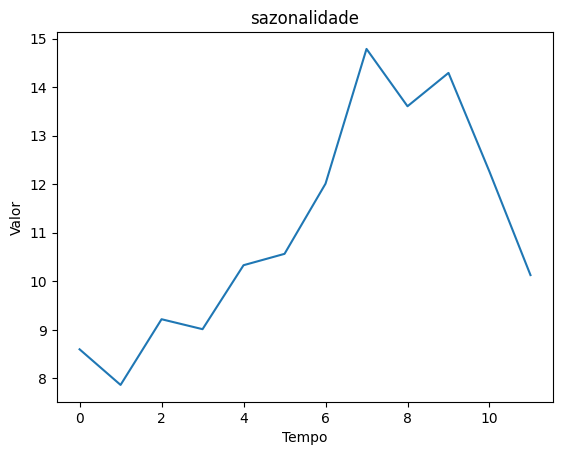

,sazonalidade
sazonalidade,
0,8.598111
1,7.863670
2,9.217900
3,9.012715
4,10.331497
5,10.565546
6,12.011995
7,14.789986
8,13.608087


In [72]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [73]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Acre - Consumo de Cimento (t)
0,2003-1,10254.061200,0.773065,0.651726,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,6.587220e+06,0.643805,247158.775150,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.598111,3.260
1,2003-2,10335.111969,0.773454,0.651847,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,6.590338e+06,0.644270,248180.775732,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,7.863670,2.191
2,2003-3,10411.052710,0.773843,0.651968,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,6.593455e+06,0.644734,249202.776314,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,9.217900,2.154
3,2003-4,10486.231639,0.774233,0.652088,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,6.596572e+06,0.645199,250224.776896,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,9.012715,2.643
4,2003-5,10566.989914,0.774622,0.652209,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,6.599689e+06,0.645663,251246.777478,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,10.331497,2.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39738.391869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.331497,NaN
245,2023-6,39713.363501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.565546,NaN
246,2023-7,39639.488252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.011995,NaN
247,2023-8,39545.723370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.789986,NaN


In [74]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      5.807
1      5.242
2      4.965
3      5.854
4      5.892
       ...  
244      NaN
245      NaN
246      NaN
247      NaN
248      NaN
Name: Acre - Consumo de Cimento (t), Length: 249, dtype: float64

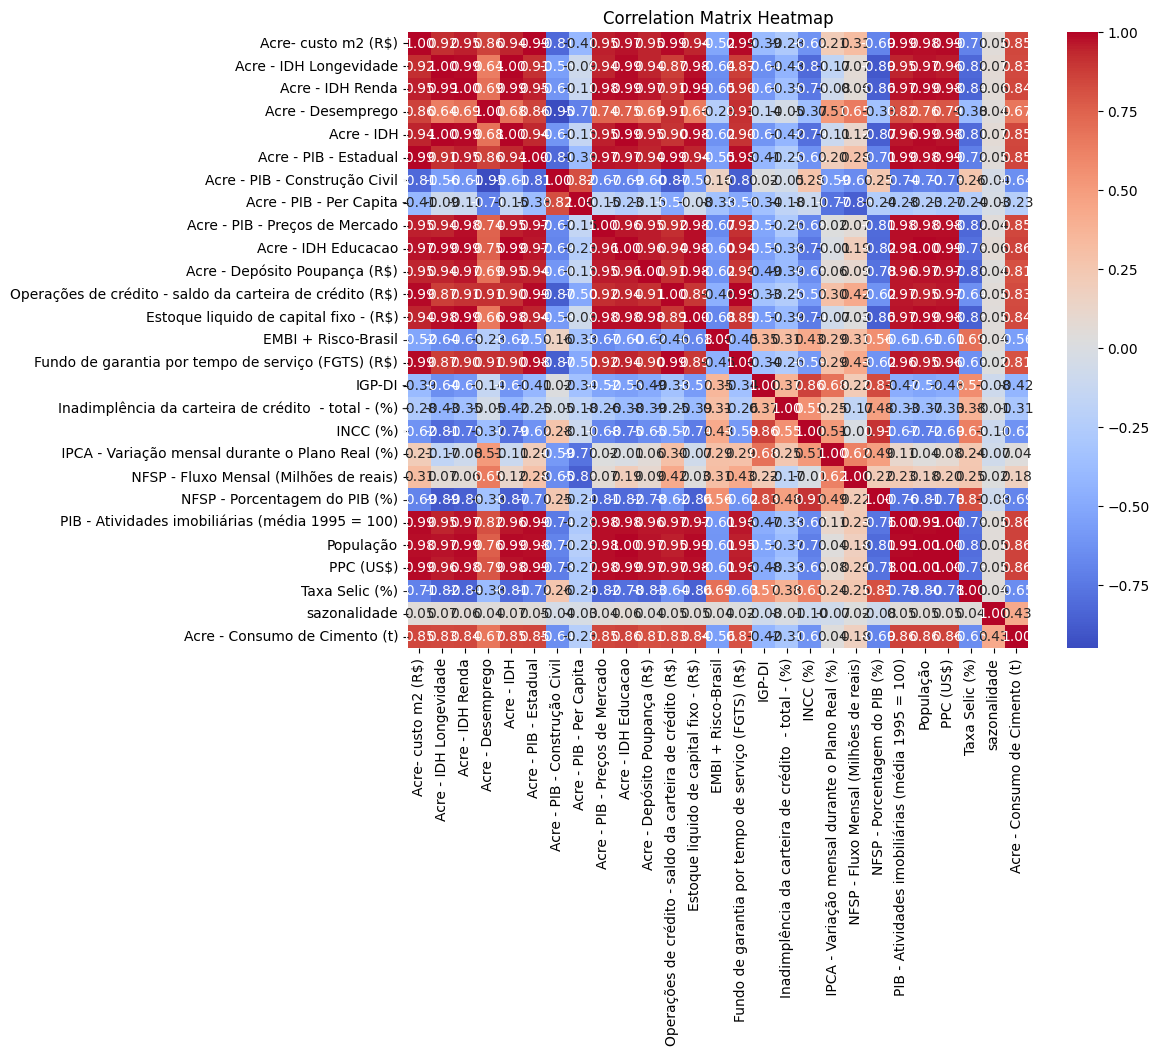

In [75]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [77]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Acre- custo m2 (R$),7.312784e+04
1,Acre - IDH Longevidade,6.816803e+05
2,Acre - IDH Renda,5.014462e+03
3,Acre - Desemprego,2.274623e+03
4,Acre - IDH,5.829510e+09
5,Acre - PIB - Estadual,1.005487e+06
6,Acre - PIB - Construção Civil,7.286093e+03
7,Acre - PIB - Per Capita,1.033225e+04
8,Acre - PIB - Preços de Mercado,3.492310e+05
9,Acre - IDH Educacao,4.760024e+05


In [78]:
# data =data.drop(['Acre- custo m2 (R$)',
#                  'Acre - IDH Longevidade',
#                  'Acre - IDH Renda', 
#                  'Acre - PIB - Estadual'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000000)
data

Num columns removed: 3


,Acre- custo m2 (R$),Acre - IDH Renda,Acre - Desemprego,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,10254.061200,0.651726,8.722906,7.285707e+06,413409.255032,9.318417,0.643805,247158.775150,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.598111
1,10335.111969,0.651847,8.718028,7.294881e+06,413607.843560,9.319990,0.644270,248180.775732,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,7.863670
2,10411.052710,0.651968,8.713149,7.304055e+06,413806.432089,9.321563,0.644734,249202.776314,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,9.217900
3,10486.231639,0.652088,8.708271,7.313229e+06,414005.020618,9.323136,0.645199,250224.776896,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,9.012715
4,10566.989914,0.652209,8.703393,7.322403e+06,414203.609146,9.324709,0.645663,251246.777478,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,10.331497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,24739.903669,0.662054,12.325404,8.610964e+06,390254.601396,9.262739,0.692789,644414.800820,3.143856e+06,7.824899e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,1.969730e+08,390.589413,1.078474,14.789986
152,24841.620960,0.662274,12.351938,8.612942e+06,390013.499227,9.259630,0.693853,643259.863253,3.159665e+06,7.823710e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,1.970500e+08,391.798431,0.962516,13.608087
153,24943.588122,0.662494,12.378471,8.614920e+06,389772.397058,9.256521,0.694916,642104.925685,3.177292e+06,7.822521e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,1.971270e+08,393.032398,1.138989,14.295584
154,25043.907661,0.662713,12.405005,8.616899e+06,389531.294889,9.253411,0.695980,640949.988118,3.192250e+06,7.821333e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,1.972040e+08,394.326420,1.038436,12.258590


In [79]:
input_data = data
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Acre- custo m2 (R$),Acre - IDH Renda,Acre - Desemprego,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.465381,-2.170172,-0.589423,-1.608944,0.198804,-1.151771,-2.038903,-1.606001,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617,-1.111428
1,-1.447932,-2.130026,-0.592895,-1.587667,0.219267,-1.115084,-2.003980,-1.599634,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013,-1.443429
2,-1.431584,-2.089880,-0.596368,-1.566391,0.239730,-1.078397,-1.969056,-1.593266,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457,-0.831255
3,-1.415399,-2.049734,-0.599841,-1.545114,0.260194,-1.041710,-1.934133,-1.586898,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128,-0.924007
4,-1.398013,-2.009587,-0.603313,-1.523837,0.280657,-1.005023,-1.899209,-1.580530,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025,-0.327858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.653188,1.261259,1.974929,1.464677,-2.187147,-2.450419,1.644526,0.869166,1.823582,0.951535,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.382734,1.398025,0.209123,1.687584
152,1.675086,1.334258,1.993816,1.469265,-2.211991,-2.522941,1.724508,0.861970,1.841017,0.944143,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.395760,1.415152,-0.182135,1.153312
153,1.697038,1.407257,2.012703,1.473853,-2.236835,-2.595462,1.804490,0.854774,1.860456,0.936751,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.408786,1.432633,0.413308,1.464092
154,1.718635,1.480256,2.031591,1.478441,-2.261679,-2.667983,1.884472,0.847578,1.876950,0.929358,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.421813,1.450965,0.074029,0.543277


In [80]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Acre- custo m2 (R$),Acre - IDH Renda,Acre - Desemprego,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.465381,-2.170172,-0.589423,-1.608944,0.198804,-1.151771,-2.038903,-1.606001,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617,-1.111428
1,-1.447932,-2.130026,-0.592895,-1.587667,0.219267,-1.115084,-2.003980,-1.599634,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013,-1.443429
2,-1.431584,-2.089880,-0.596368,-1.566391,0.239730,-1.078397,-1.969056,-1.593266,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457,-0.831255
3,-1.415399,-2.049734,-0.599841,-1.545114,0.260194,-1.041710,-1.934133,-1.586898,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128,-0.924007
4,-1.398013,-2.009587,-0.603313,-1.523837,0.280657,-1.005023,-1.899209,-1.580530,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025,-0.327858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.391681,0.851255,1.702509,1.397559,-1.637049,-1.371678,1.069364,1.152620,1.517172,1.018624,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.222749,1.245801,-0.282621,1.687584
140,1.412710,0.831057,1.730551,1.404559,-1.712287,-1.485897,1.072422,1.106004,1.549848,1.015555,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.236509,1.254608,-0.612121,1.153312
141,1.433970,0.810859,1.758593,1.411559,-1.787525,-1.600115,1.075480,1.059387,1.588878,1.012487,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.250269,1.263636,-0.137902,1.464092
142,1.455244,0.790662,1.786635,1.418559,-1.862762,-1.714333,1.078538,1.012771,1.625721,1.009418,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.264029,1.272935,-0.332143,0.543277


In [81]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       5.807000
1       5.242000
2       4.965000
3       5.854000
4       5.892000
         ...    
139    16.712957
140    15.538329
141    16.292610
142    14.099814
143    11.828000
Name: Acre - Consumo de Cimento (t), Length: 144, dtype: float64

In [82]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [83]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 23)

In [84]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Acre- custo m2 (R$),Acre - IDH Renda,Acre - Desemprego,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
108,0.730856,0.797912,0.557783,0.802906,-0.425881,0.364385,0.697161,0.708281,0.595959,0.890825,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.754385,0.812014,-1.082183,-1.111428
109,0.752350,0.832783,0.604534,0.829402,-0.457297,0.341204,0.713448,0.733185,0.621380,0.900214,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.770574,0.831569,-1.036767,-1.443429
110,0.773272,0.867655,0.651284,0.855899,-0.488713,0.318023,0.729736,0.758089,0.652999,0.909602,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.786763,0.850791,-0.752482,-0.831255
111,0.793984,0.902526,0.698035,0.882395,-0.520128,0.294842,0.746024,0.782992,0.685630,0.918990,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.802953,0.868783,-1.088413,-0.924007
112,0.814894,0.937398,0.744785,0.908892,-0.551544,0.271661,0.762312,0.807896,0.717515,0.928378,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.819142,0.886720,-1.508135,-0.327858
113,0.834624,0.972269,0.791536,0.935388,-0.582960,0.248481,0.778600,0.832799,0.747579,0.937766,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.835331,0.905151,-1.474280,-0.222057
114,0.857967,1.007141,0.838286,0.961885,-0.614376,0.225300,0.794888,0.857703,0.775262,0.947155,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.851520,0.923702,-1.463452,0.431805
115,0.881749,1.042013,0.885037,0.988382,-0.645791,0.202119,0.811176,0.882607,0.805205,0.956543,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.867709,0.942382,-1.236037,1.687584
116,0.901518,1.076884,0.931788,1.014878,-0.677207,0.178938,0.827463,0.907510,0.836796,0.965931,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.883899,0.960385,-0.935721,1.153312
117,0.921562,1.111756,0.978538,1.041375,-0.708623,0.155757,0.843751,0.932414,0.876422,0.975319,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.900088,0.977769,-1.241995,1.464092


In [85]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 23)

In [86]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [87]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [88]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [89]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1630752824, 524241000, 644423611, 2801665379, 2345605309, 1343234472, 881278796, 2571128127, 498784822, 113349394]


Step: 0 ___________________________________________
val_loss: 1.431306004524231
winner_seed: 1630752824


Step: 1 ___________________________________________
val_loss: 1.6645770072937012


Step: 2 ___________________________________________
val_loss: 1.5913745164871216


Step: 3 ___________________________________________
val_loss: 1.475913643836975


Step: 4 ___________________________________________
val_loss: 1.964929461479187


Step: 5 ___________________________________________
val_loss: 1.285535454750061
winner_seed: 1343234472


Step: 6 ___________________________________________
val_loss: 1.2913899421691895


Step: 7 ___________________________________________
val_loss: 1.2482402324676514
winner_seed: 2571128127


Step: 8 ___________________________________________
val_loss: 1.834213376045227


Step: 9 ___________________________________________
val_loss: 1.7196

In [90]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 281ms/step - loss: 198.1931 - val_loss: 161.4084
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 101.8424 - val_loss: 17.6337
Epoch 3/10000
4/4 [==============================] - 0s 8ms/step - loss: 29.6204 - val_loss: 9.9977
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.7394 - val_loss: 9.3167
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.5242 - val_loss: 11.5618
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.4093 - val_loss: 7.3008
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.4667 - val_loss: 9.1756
Epoch 8/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.1710 - val_loss: 13.5701
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.7320 - val_loss: 10.9468
Epoch 10/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.4188 - val_lo

4/4 [==============================] - 0s 8ms/step - loss: 10.7079 - val_loss: 13.0735
Epoch 82/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.1326 - val_loss: 15.9226
Epoch 83/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.5137 - val_loss: 15.9449
Epoch 84/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.8061 - val_loss: 31.6712
Epoch 85/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.8200 - val_loss: 16.8226
Epoch 86/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.5538 - val_loss: 16.6154
Epoch 87/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.8742 - val_loss: 8.6435
Epoch 88/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.7045 - val_loss: 9.4074
Epoch 89/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.8245 - val_loss: 8.3636
Epoch 90/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.6830 - val_loss: 9.8892
Ep

4/4 [==============================] - 0s 8ms/step - loss: 5.8090 - val_loss: 13.3944
Epoch 162/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.5993 - val_loss: 12.1124
Epoch 163/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.3902 - val_loss: 12.9151
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8635 - val_loss: 8.6635
Epoch 165/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6372 - val_loss: 12.4250
Epoch 166/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.9627 - val_loss: 9.9460
Epoch 167/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2744 - val_loss: 8.0711
Epoch 168/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5594 - val_loss: 8.0596
Epoch 169/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.8061 - val_loss: 14.9361
Epoch 170/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8671 - val_loss: 22.9410


4/4 [==============================] - 0s 8ms/step - loss: 4.2926 - val_loss: 2.7773
Epoch 243/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1803 - val_loss: 10.9454
Epoch 244/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4027 - val_loss: 4.4635
Epoch 245/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1806 - val_loss: 7.7422
Epoch 246/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0121 - val_loss: 3.5965
Epoch 247/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6992 - val_loss: 3.1461
Epoch 248/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9114 - val_loss: 4.6487
Epoch 249/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9873 - val_loss: 5.2476
Epoch 250/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7645 - val_loss: 2.7750
Epoch 251/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.3497 - val_loss: 2.2435
Epoch

4/4 [==============================] - 0s 8ms/step - loss: 4.4539 - val_loss: 13.2041
Epoch 324/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.9166 - val_loss: 3.6303
Epoch 325/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9867 - val_loss: 5.4840
Epoch 326/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7759 - val_loss: 4.4510
Epoch 327/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8890 - val_loss: 2.4668
Epoch 328/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7891 - val_loss: 1.9343
Epoch 329/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1123 - val_loss: 3.7837
Epoch 330/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6814 - val_loss: 2.7317
Epoch 331/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3748 - val_loss: 2.1110
Epoch 332/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5056 - val_loss: 2.4464
Epoch

4/4 [==============================] - 0s 7ms/step - loss: 4.0249 - val_loss: 5.3958
Epoch 405/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5576 - val_loss: 5.3090
Epoch 406/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5941 - val_loss: 3.6521
Epoch 407/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4005 - val_loss: 2.5636
Epoch 408/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7844 - val_loss: 5.2719
Epoch 409/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4147 - val_loss: 3.3984
Epoch 410/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6886 - val_loss: 2.5622
Epoch 411/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3454 - val_loss: 2.9785
Epoch 412/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7374 - val_loss: 10.1470
Epoch 413/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8645 - val_loss: 2.5028
Epoch

4/4 [==============================] - 0s 8ms/step - loss: 3.4557 - val_loss: 17.0676
Epoch 486/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0415 - val_loss: 4.2597
Epoch 487/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3542 - val_loss: 11.4013
Epoch 488/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0891 - val_loss: 7.2770
Epoch 489/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5083 - val_loss: 8.9314
Epoch 490/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4433 - val_loss: 6.5419
Epoch 491/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4635 - val_loss: 4.8665
Epoch 492/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7198 - val_loss: 4.7791
Epoch 493/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6628 - val_loss: 7.3218
Epoch 494/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4722 - val_loss: 10.7850
Epo

4/4 [==============================] - 0s 7ms/step - loss: 3.2908 - val_loss: 7.6315
Epoch 567/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8105 - val_loss: 7.3459
Epoch 568/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4523 - val_loss: 8.3529
Epoch 569/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5544 - val_loss: 3.2875
Epoch 570/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8226 - val_loss: 2.0962
Epoch 571/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.4810 - val_loss: 7.0649
Epoch 572/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2295 - val_loss: 4.9615
Epoch 573/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3975 - val_loss: 3.6082
Epoch 574/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.6634 - val_loss: 4.3946
Epoch 575/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2403 - val_loss: 4.0619
Epoch 

4/4 [==============================] - 0s 8ms/step - loss: 3.2279 - val_loss: 3.1617
Epoch 648/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2183 - val_loss: 4.5812
Epoch 649/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2175 - val_loss: 3.0983
Epoch 650/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0412 - val_loss: 2.2665
Epoch 651/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4754 - val_loss: 5.5539
Epoch 652/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3193 - val_loss: 1.8976
Epoch 653/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4048 - val_loss: 2.0920
Epoch 654/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4958 - val_loss: 1.7343
Epoch 655/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2025 - val_loss: 2.1777
Epoch 656/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4052 - val_loss: 2.9108
Epoch 

4/4 [==============================] - 0s 7ms/step - loss: 3.2741 - val_loss: 7.8250
Epoch 729/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1876 - val_loss: 6.9052
Epoch 730/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0360 - val_loss: 5.3024
Epoch 731/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.3050 - val_loss: 6.7505
Epoch 732/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2811 - val_loss: 4.6495
Epoch 733/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3995 - val_loss: 8.4813
Epoch 734/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0441 - val_loss: 7.6850
Epoch 735/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9898 - val_loss: 6.5145
Epoch 736/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3135 - val_loss: 6.2686
Epoch 737/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2336 - val_loss: 13.8994
Epoch

4/4 [==============================] - 0s 7ms/step - loss: 2.9523 - val_loss: 8.8505
Epoch 810/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6177 - val_loss: 9.4770
Epoch 811/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5697 - val_loss: 10.5827
Epoch 812/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2404 - val_loss: 4.3233
Epoch 813/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0474 - val_loss: 4.4625
Epoch 814/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9192 - val_loss: 4.9916
Epoch 815/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0895 - val_loss: 3.3421
Epoch 816/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4613 - val_loss: 5.1412
Epoch 817/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0858 - val_loss: 5.2945
Epoch 818/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2337 - val_loss: 3.5984
Epoch

4/4 [==============================] - 0s 8ms/step - loss: 2.8603 - val_loss: 5.1072
Epoch 891/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8033 - val_loss: 3.8408
Epoch 892/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0080 - val_loss: 8.5487
Epoch 893/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3704 - val_loss: 8.9025
Epoch 894/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2779 - val_loss: 6.8398
Epoch 895/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3045 - val_loss: 9.3123
Epoch 896/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8948 - val_loss: 11.6881
Epoch 897/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1754 - val_loss: 10.3855
Epoch 898/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.9840 - val_loss: 8.3927
Epoch 899/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8450 - val_loss: 3.5351
Epoc

4/4 [==============================] - 0s 8ms/step - loss: 2.6584 - val_loss: 7.4922
Epoch 972/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3071 - val_loss: 8.6711
Epoch 973/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0517 - val_loss: 9.6547
Epoch 974/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8232 - val_loss: 7.9808
Epoch 975/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3830 - val_loss: 6.7911
Epoch 976/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.8451 - val_loss: 7.0934
Epoch 977/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8516 - val_loss: 4.4380
Epoch 978/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3068 - val_loss: 8.5058
Epoch 979/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8878 - val_loss: 6.5521
Epoch 980/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9719 - val_loss: 6.4371
Epoch 

4/4 [==============================] - 0s 8ms/step - loss: 2.9169 - val_loss: 10.4723
Epoch 1052/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7437 - val_loss: 8.9044
Epoch 1053/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6998 - val_loss: 5.7054
Epoch 1054/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0546 - val_loss: 7.2145
Epoch 1055/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2611 - val_loss: 10.4276
Epoch 1056/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0320 - val_loss: 8.8427
Epoch 1057/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9076 - val_loss: 7.2948
Epoch 1058/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7690 - val_loss: 8.1177
Epoch 1059/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.9599 - val_loss: 6.6094
Epoch 1060/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7044 - val_loss: 7.

4/4 [==============================] - 0s 7ms/step - loss: 3.1098 - val_loss: 9.1967
Epoch 1132/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8862 - val_loss: 8.0391
Epoch 1133/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7733 - val_loss: 7.3735
Epoch 1134/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.6532 - val_loss: 7.4679
Epoch 1135/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6812 - val_loss: 5.4164
Epoch 1136/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7869 - val_loss: 6.1561
Epoch 1137/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6039 - val_loss: 4.2754
Epoch 1138/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1568 - val_loss: 6.5488
Epoch 1139/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7113 - val_loss: 2.3144
Epoch 1140/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8555 - val_loss: 8.69

4/4 [==============================] - 0s 7ms/step - loss: 2.7685 - val_loss: 6.2279
Epoch 1212/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5602 - val_loss: 7.9388
Epoch 1213/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6553 - val_loss: 6.6171
Epoch 1214/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.6164 - val_loss: 5.5327
Epoch 1215/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4815 - val_loss: 6.2851
Epoch 1216/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6130 - val_loss: 8.3535
Epoch 1217/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.8746 - val_loss: 7.4784
Epoch 1218/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6010 - val_loss: 7.0666
Epoch 1219/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.6103 - val_loss: 7.7150
Epoch 1220/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7609 - val_loss: 10.1

4/4 [==============================] - 0s 7ms/step - loss: 2.6348 - val_loss: 5.4289
Epoch 1292/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6477 - val_loss: 5.3557
Epoch 1293/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5985 - val_loss: 5.3814
Epoch 1294/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.6192 - val_loss: 4.9250
Epoch 1295/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6047 - val_loss: 4.1125
Epoch 1296/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6173 - val_loss: 4.3763
Epoch 1297/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2585 - val_loss: 3.5497
Epoch 1298/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5656 - val_loss: 4.8477
Epoch 1299/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3796 - val_loss: 5.0888
Epoch 1300/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.4599 - val_loss: 5.77

In [91]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [92]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,10.564136,10.163313,10.412293,11.134674,12.135677,13.286377,14.433602,15.610323,16.678205,16.637484,15.776873,14.248144
Target,10.406,9.081,9.545,10.13,14.451,13.218,13.552,15.826,14.869,14.734,12.754,11.925
Error,0.158135,1.082313,0.867293,1.004674,2.315323,0.068377,0.881602,0.215677,1.809205,1.903483,3.022873,2.323144


In [93]:
display(mae)
display(mape)

1.3043417

0.10426571

In [94]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [95]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[161.0811]] - Target[150.491]| =  Error: [[10.590103]]; MAPE:[[0.07037035]]


[array([[10.590103]], dtype=float32)]

10.590103

0.07037035